In [59]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from statistics import mode


In [60]:
def load_config():
    # Get the absolute path of the project root (one directory up)
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

    # Normalize the project_root to ensure it's correctly formatted
    project_root = os.path.normpath(project_root)
    
    config_path = os.path.join(project_root, 'config.json')

    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Config file not found at expected location: {config_path}")

    with open(config_path, 'r') as f:
        config = json.load(f)

    return config, project_root


In [61]:
config, project_root = load_config()

csv_path_enterprise = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_groups_v15"]["enterprise"]))
csv_path_mobile = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_groups_v15"]["mobile"]))
csv_path_ics = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_groups_v15"]["ics"]))

In [62]:
# Helper function to load 'techniques used by group in all the domains' data
def load_techniques_used_group(file_path):
    df = pd.read_excel(file_path, sheet_name='techniques used')
    return df[['source ID', 'target ID', 'target name']]

# Combine all domains
dfs = [load_techniques_used_group(f) for f in [csv_path_enterprise, csv_path_mobile, csv_path_ics]]
combined_df = pd.concat(dfs, ignore_index=True)


In [63]:
len(combined_df)

3433


Filtered matrix shape: (10, 10)
Top groups: ['G0040', 'G0069', 'G0121', 'G0142', 'G1018', 'G0129', 'G0060', 'G0087', 'G0091', 'G0021']
Creating Jaccard similarity heatmap for top 10 groups...


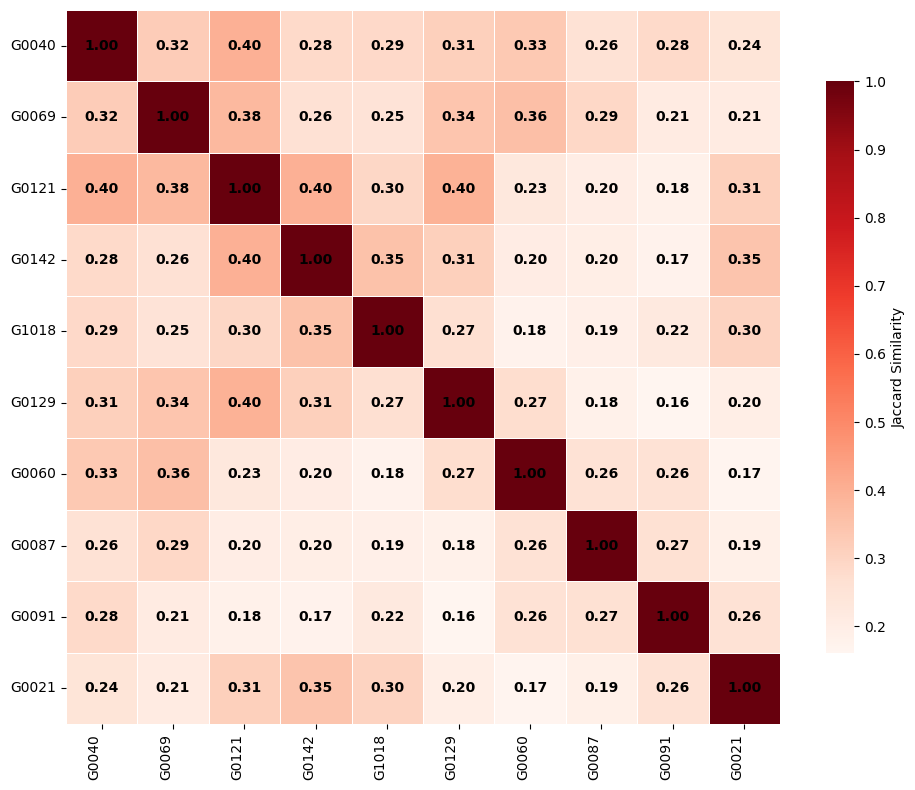


Top pairs among the selected 10 groups:

G0040 - G0121: 0.400
G0121 - G0142: 0.400
G0121 - G0129: 0.396
G0069 - G0121: 0.375
G0069 - G0060: 0.361
G0142 - G1018: 0.353
G0142 - G0021: 0.346
G0069 - G0129: 0.342
G0040 - G0060: 0.333
G0040 - G0069: 0.324
G0121 - G0021: 0.314
G0040 - G0129: 0.312
G0142 - G0129: 0.312
G1018 - G0021: 0.303
G0121 - G1018: 0.295


In [64]:
# Build binary group-technique matrix
group_tech_matrix = pd.crosstab(combined_df['source ID'], combined_df['target ID'])
binary_matrix = group_tech_matrix.astype(bool).astype(int)

# Compute intersection between groups
intersection = binary_matrix.dot(binary_matrix.T)

# Compute counts per group (for union calculation)
group_counts = binary_matrix.sum(axis=1)

# Compute union matrix: |A| + |B| - |A ∩ B|
union = group_counts.values[:, None] + group_counts.values[None, :] - intersection.values

# Compute Jaccard similarity matrix
jaccard_similarity = intersection / union
jaccard_similarity = jaccard_similarity.fillna(0)

# Find top 10 groups with highest average Jaccard similarities
def get_top_groups_by_jaccard(jaccard_similarity, top_n=10):
    # Calculate average similarity for each group (excluding self-similarity)
    avg_similarities = []
    group_names = jaccard_similarity.index.tolist()
    
    for i, group in enumerate(group_names):
        # Get all similarities for this group, excluding diagonal (self-similarity)
        similarities = []
        for j, other_group in enumerate(group_names):
            if i != j:  # Exclude self-similarity
                similarities.append(jaccard_similarity.iloc[i, j])
        
        avg_sim = np.mean(similarities) if similarities else 0
        avg_similarities.append((group, avg_sim))
    
    # Sort by average similarity and get top N
    avg_similarities.sort(key=lambda x: x[1], reverse=True)
    top_groups = [group for group, _ in avg_similarities[:top_n]]
    
    return top_groups

# Get top 10 groups
top_groups = get_top_groups_by_jaccard(jaccard_similarity, top_n=10)

# Filter the Jaccard similarity matrix to include only top groups
jaccard_similarity_top = jaccard_similarity.loc[top_groups, top_groups]

print(f"\nFiltered matrix shape: {jaccard_similarity_top.shape}")
print(f"Top groups: {top_groups}")

# Create matplotlib heatmap for top groups
def create_jaccard_heatmap_matplotlib(jaccard_similarity_filtered):
    # Set up the matplotlib figure
    plt.figure(figsize=(10, 8))
    
    # Create the heatmap using seaborn for better styling
    ax = sns.heatmap(
        jaccard_similarity_filtered,
        annot=True,  # Show values in cells
        fmt='.2f',   # Format numbers to 2 decimal places
        cmap='Reds', # Red colormap to match your image
        square=True, # Make cells square
        linewidths=0.5,  # Add thin lines between cells
        cbar_kws={"shrink": 0.8, "label": "Jaccard Similarity"},
        annot_kws={"size": 10, "color": "black", "weight": "bold"}  # Text styling
    )
    
    # Customize the plot
    #plt.title('Jaccard Similarity Matrix - Top 10 Groups', fontsize=16, pad=20)
    plt.xlabel('')
    plt.ylabel('')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90, ha='right')
    plt.yticks(rotation=0)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt.gcf()

# Alternative version with more control (pure matplotlib) - for top groups
def create_jaccard_heatmap_matplotlib_detailed(jaccard_similarity_filtered):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create the heatmap
    im = ax.imshow(jaccard_similarity_filtered, cmap='Reds', aspect='auto', vmin=0, vmax=1)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Jaccard Similarity', rotation=270, labelpad=20)
    
    # Set ticks and labels
    group_names = jaccard_similarity_filtered.index.tolist()
    ax.set_xticks(np.arange(len(group_names)))
    ax.set_yticks(np.arange(len(group_names)))
    ax.set_xticklabels(group_names, rotation=45, ha='right')
    ax.set_yticklabels(group_names)
    
    # Move x-axis labels to top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    # Add text annotations
    for i in range(len(group_names)):
        for j in range(len(group_names)):
            value = jaccard_similarity_filtered.iloc[i, j]
            if i == j:
                text = '1.00'
            else:
                text = f'{value:.2f}'
            ax.text(j, i, text, ha='center', va='center', 
                   color='black', fontsize=10, weight='bold')
    
    # Add title
    #ax.set_title('Jaccard Similarity Matrix - Top 10 Groups', fontsize=16, pad=20)
    
    # Remove axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

# Create and display the heatmap (using seaborn version - cleaner)
print("Creating Jaccard similarity heatmap for top 10 groups...")

fig = create_jaccard_heatmap_matplotlib(jaccard_similarity_top)
plt.savefig('figure/jaccard_similarity_group_10.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Print top pairs from the filtered groups
group_ids = jaccard_similarity_top.index.tolist()
top_pairs = []
for i in range(len(group_ids)):
    for j in range(i + 1, len(group_ids)):
        score = jaccard_similarity_top.iat[i, j]
        top_pairs.append((group_ids[i], group_ids[j], score))

# Sort pairs by similarity score descending
top_pairs_sorted = sorted(top_pairs, key=lambda x: x[2], reverse=True)

# Print top pairs among the selected groups
print(f"\nTop pairs among the selected {len(top_groups)} groups:\n")
for g1, g2, score in top_pairs_sorted[:15]:
    print(f"{g1} - {g2}: {score:.3f}")

# Optional: Save the figure

# plt.savefig('jaccard_similarity_heatmap.pdf', bbox_inches='tight')

In [65]:
# Convert the similarity matrix to a NumPy array
jaccard_values = jaccard_similarity.values

# Mask out the diagonal (self-similarity)
mask = ~np.eye(jaccard_values.shape[0], dtype=bool)

# Extract all off-diagonal similarity scores
off_diag_values = jaccard_values[mask]

# Compute statistics
mean_score = np.mean(off_diag_values)
median_score = np.median(off_diag_values)
max_score = np.max(off_diag_values)

print(f"Mean Jaccard similarity (excluding self-comparison): {mean_score:.4f}")
print(f"Median Jaccard similarity (excluding self-comparison): {median_score:.4f}")
print(f"Max Jaccard similarity (excluding self-comparison): {max_score:.4f}")


Mean Jaccard similarity (excluding self-comparison): 0.0770
Median Jaccard similarity (excluding self-comparison): 0.0606
Max Jaccard similarity (excluding self-comparison): 0.5556
